In [3]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [6]:
import findspark
from functools import reduce
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import plotly as py
import matplotlib.pyplot as plt

In [ ]:
#connecting to a spark cluster
# sc = SparkContext("local", "firstSpark")

In [8]:
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

In [10]:
# df = spark.read.format('csv').options(header='true').load(".")
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

In [11]:
#creating a dataframe
df_matches = load_dataframe('C:\Users\SAMAD\Downloads\Datasets\Matches.csv')
df_matches.limit(5).show()

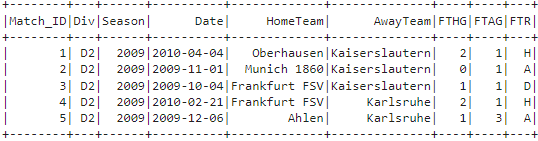

In [14]:
#converting to pandas dataframe
df_matches.limit(5).toPandas()

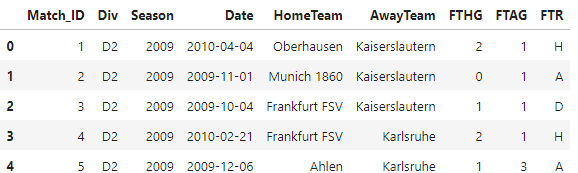

In [19]:
#renaming few columns.
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

In [21]:
df_matches.limit(5).toPandas()

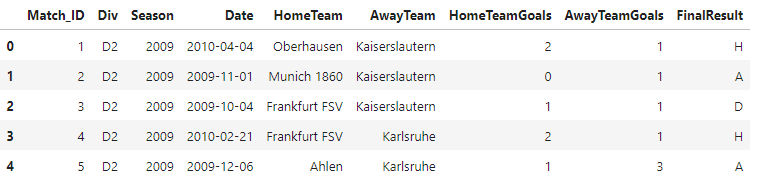

In [23]:
#finding the null count in each column
matches.select([count(when(isnan(column), column)).alias(column) for column in matches.columns]).show()
[df_matches.filter(col(column).isNull()).count() for column in df_matches.columns]

In [ ]:
Who are the winners Bundesliga in the last decade?

In [25]:
#FinalResult
df_matches.limit(5).toPandas()

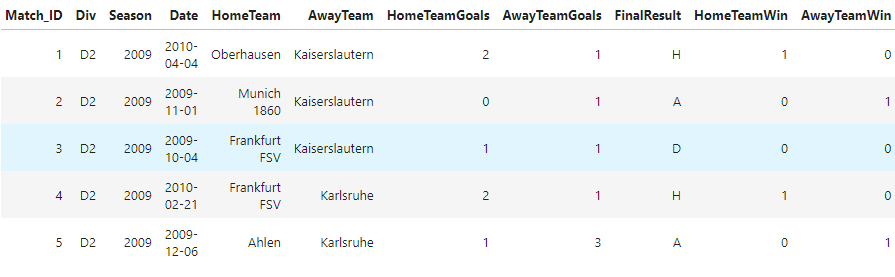

In [36]:
df_matches = df_matches.withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
                        .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
                        .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


#bundesliga is a D1 division and we looking in season 2000 - 2010
bundesliga = df_matches \
                    .filter((col('Season') >= 2000) & 
                            (col('Season') <= 2010) & 
                            (col('Div') == 'D1'))

# home team
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

#away game 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

#seasons
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 

table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df

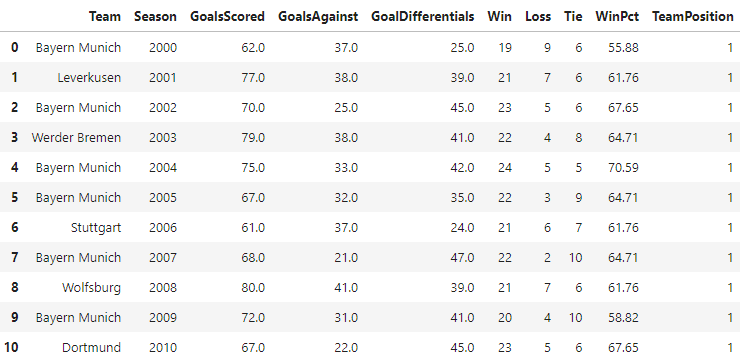

In [51]:
# window = Window.partitionBy('Team').orderby('WinPct')
table.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).toPandas().round(1)

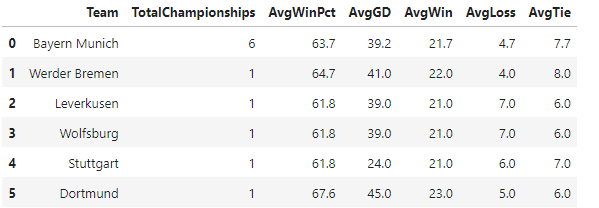

In [54]:
df_teams = load_dataframe('C:\Users\SAMAD\Downloads\Datasets\Teams.csv')
df_teams.limit(5).toPandas()

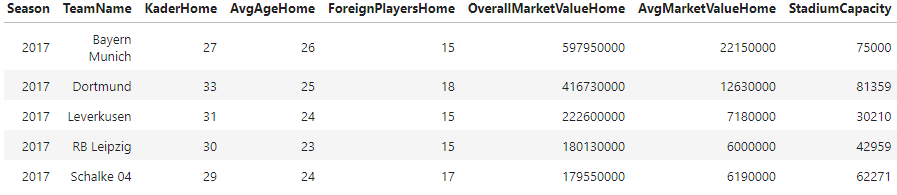

In [ ]:
Which teams have been relegated in the past 2000 - 2010 years?

In [63]:
# data for 2000s
relegated = table.filter((col('TeamPosition') == 16) | 
             (col('TeamPosition') == 17) |
             (col('TeamPosition') == 18)).orderBy(asc('Season')) 
relegated.filter(col('Season') == 2000).toPandas()

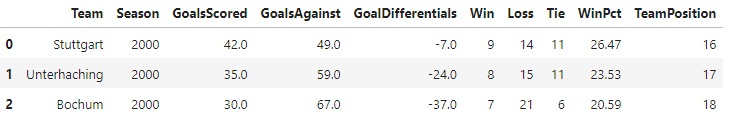

In [ ]:
Checking if Oktoberfest has any effect on the performance of the overall league?

In [66]:
df_matches.limit(5).toPandas()

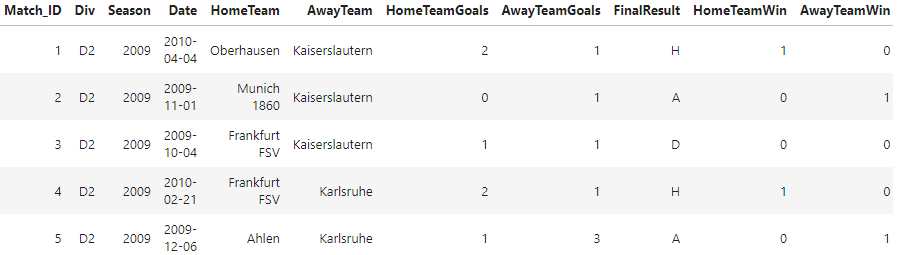

In [88]:
oktoberfest = df_matches \
                .filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

oktoberfest_df = oktoberfest.toPandas()

oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals_to_games_ratio')
plt.show()


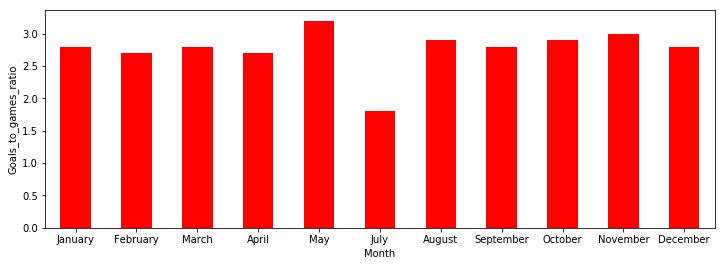

In [93]:
oktoberfest_df['GameTie_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('GameTie_to_games_ratio')
plt.show()

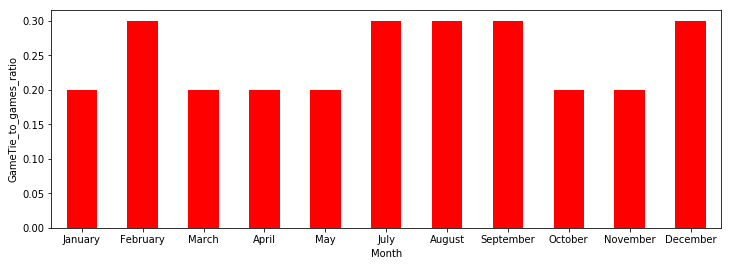